In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy import stats

In [3]:
# Erdos-Renyi Network
# Grouping of different age categories for subsequent analyses
# The infection rates for different age groups are based on data searched

def age_based_infection_rate(node_age, base_infection_rate):
    if 0 < node_age < 5:
        return 0.726  
    elif 4 < node_age < 10:
        return 0.9027 
    elif 9< node_age < 15:
        return 0.1753
    elif 14 < node_age < 20:
        return 0.0291
    else :
        return base_infection_rate


In [4]:
# Erdos-Renyi Network

def sir_model_er(N, i, r, k, initial_infected, timesteps, age, initial_age):
    # Create an Erdos-Renyi using nx
    # probability of edge formation
    p = k / (N - 1)  
    G = nx.fast_gnp_random_graph(N, p)

    # Assign ages to nodes based on the provided age distribution
    ages = {node: np.random.choice(age) for node in G.nodes()}
    prevalence_by_age = {age_group: [0] for age_group in initial_age.keys()}

    # Initialize the infection based on age groups
    infected = set()
    # given the initial infected fraction, randomly assign nodes to be infected per age group
    for age_group, fraction in initial_age.items():
        # Nodes within age group
        age_group_nodes = [node for node, age in ages.items() if age_group[0] <= age <= age_group[1]]
        # Choose random nodes infected initially
        num_initial_infected = min(len(age_group_nodes), int(fraction * initial_infected))
        initial_infected_n = np.random.choice(age_group_nodes, size=num_initial_infected, replace=False)
        infected.update(initial_infected_n)

    # Calculate susceptible nodes
    susceptible = set(G.nodes()) - infected
    # Set of recovered nodes is empty initially
    recovered = set()
    
    # Record the prevalence over time
    # Susceptible nodes initially
    S = [len(susceptible)]
    # Infected nodes initially
    I = [len(infected)]
    # Recovered nodes initially
    R = [len(recovered)]
    # Prevalence initially
    prevalence = [len(infected) / N]
    # List for infected individuals by different age groups per timestep
    infected_ages = []

    # Simulate the spread over time
    for _ in range(timesteps):
        new_infected = set()
        new_recovered = set()
        
        # Transmit infection based on infection rates for age groups
        for node in set(infected):
            node_age = ages[node]
            age_i = age_based_infection_rate(node_age, i)
            
            # Infect neighbors
            for neighbor in G.neighbors(node):
                # Infect susceptible nodes for age-related infection rate
                if neighbor in susceptible and np.random.random() < age_i:
                    new_infected.add(neighbor)
            # Probability for recovery
            if np.random.random() < r:
                new_recovered.add(node)
                infected.remove(node)
        
        # Prevalence for different age groups
        for age_group in initial_age.keys():
            infected_in_age_group = sum(1 for node in infected if age_group[0] <= ages[node] <= age_group[1])
            prevalence_by_age[age_group].append(infected_in_age_group / N)

        infected.update(new_infected)
        recovered.update(new_recovered)
        susceptible -= new_infected
        # infected_ages.append([ages[node] for node in infected])
        new_infected_ages = [ages[node] for node in new_infected]
        infected_ages.append(new_infected_ages)

        S.append(len(susceptible))
        I.append(len(infected))
        R.append(len(recovered))
        prevalence.append(len(infected) / N)

    return S, I, R, prevalence, infected_ages, prevalence_by_age


In [5]:
# Parameters

# Total nodes in the network
N = 100000
# Fraction of infected nodes initially
initial_infected_fraction = 0.5
# Time steps of simulation
timesteps = 20
# Number of initial infected nodes
initial_infected = int(N * initial_infected_fraction)
# Fraction of immnue nodes initially
immune_count = 0.5
# Rate of nodes become immune each time step
immune_rate = 0.001
# Number of simulations to average over 
simulations = 30  
# Range of age
age = range(21) 

initial_age = {
    (0, 4): 0.1, 
    (5, 9): 0.2, 
    (10, 14): 0.2,
    (15, 20): 0.5
}
# Parameter for infection rate
i_1 = 0.0033
# Parameter for node degree in this network
k_1 = 3.0
# Parameter for recovery rate
r = 0.9

In [6]:
# Dictionary to store prevalence by various age groups
prevalence_by_age_across_simulations = {age_group: [] for age_group in initial_age.keys()}

S, I, R, _ , infected_ages, _= sir_model_er(N, i_1, r, k_1, initial_infected, timesteps, age, initial_age)
prevalence = []
infected_ages = [age for ages in infected_ages for age in ages]

# For simulations
for _ in range(simulations):
    _, _, _, preva_all, _, prevalence_by_age = sir_model_er(N, i_1, r, k_1, initial_infected, timesteps, age, initial_age)
    prevalence.append(preva_all)
    for age_group in initial_age.keys():
        prevalence_by_age_across_simulations[age_group].append(prevalence_by_age[age_group])
        
# Calculate average prevalence
avg_prevalence = np.mean(prevalence, axis=0)
avg_prevalence_by_age = {age_group: np.mean(prevalence_by_age_across_simulations[age_group], axis=0) for age_group in initial_age.keys()}

# Add error bars to prevalence
std_prevalence = np.std(prevalence, axis=0)

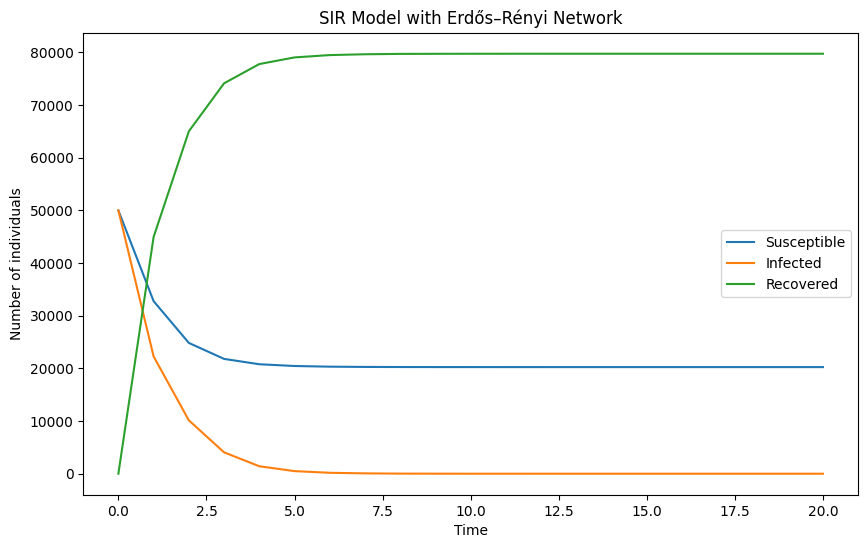

In [7]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(S, label='Susceptible')
plt.plot(I, label='Infected')
plt.plot(R, label='Recovered')
plt.xlabel('Time')
plt.ylabel('Number of individuals')
plt.legend()
plt.title('SIR Model with Erdős–Rényi Network')
plt.show()

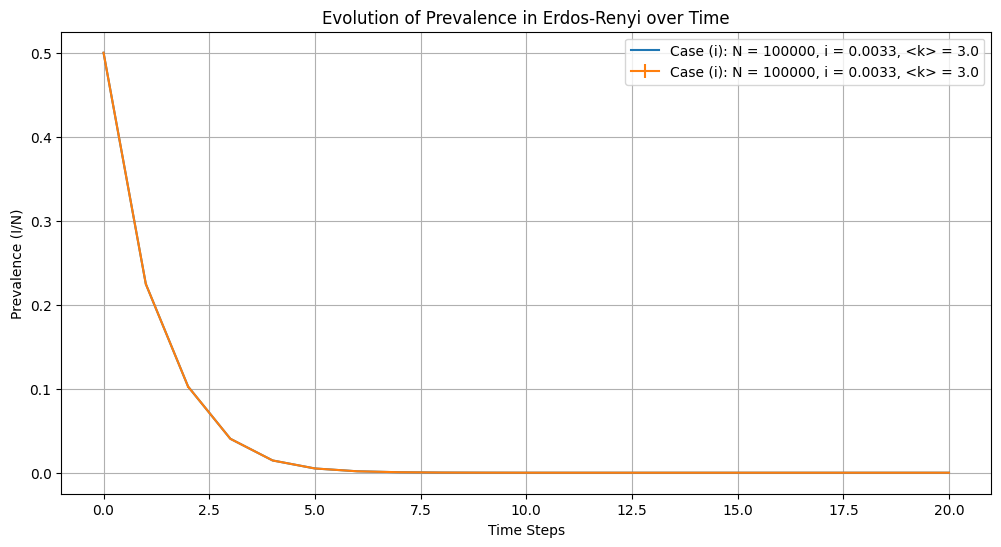

In [8]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(avg_prevalence, label=f'Case (i): N = {N}, i = {i_1}, <k> = {k_1}')
plt.xlabel('Time Steps')
plt.ylabel('Prevalence (I/N)')
plt.errorbar(range(len(avg_prevalence)), avg_prevalence, yerr=std_prevalence, label=f'Case (i): N = {N}, i = {i_1}, <k> = {k_1}')
plt.title('Evolution of Prevalence in Erdos-Renyi over Time')
plt.legend()
plt.grid(True)
plt.show()

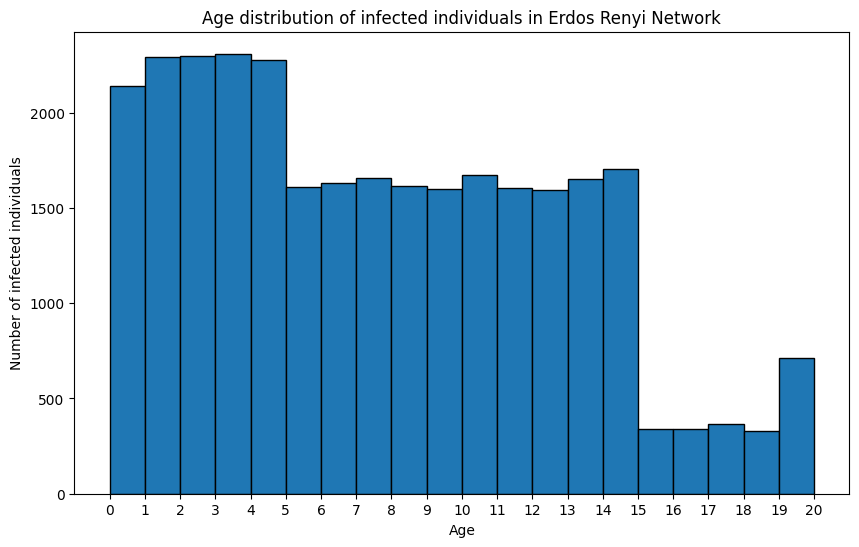

In [9]:
# Histogram of infected ages
plt.figure(figsize=(10, 6))
plt.hist(infected_ages, bins=range(21), edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Number of infected individuals')
plt.title('Age distribution of infected individuals in Erdos Renyi Network')
plt.xticks(range(21))
plt.show()

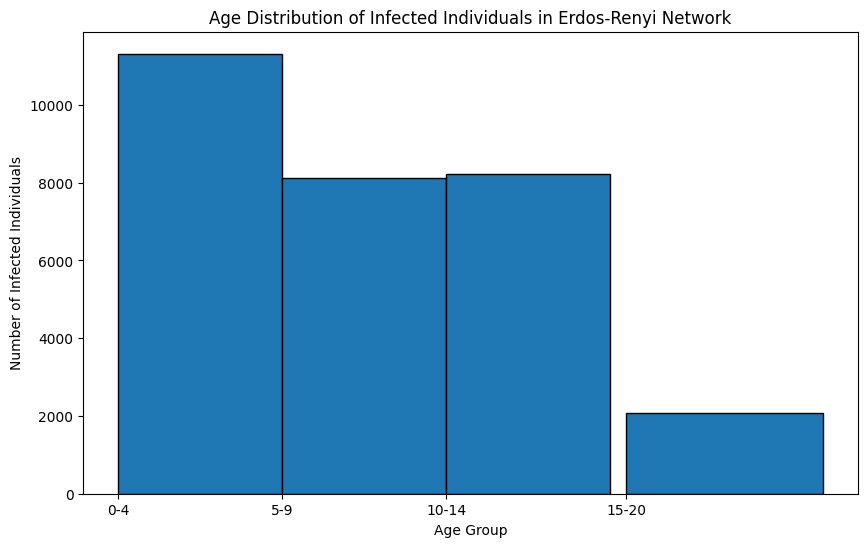

In [10]:
# Define age group bins for the histogram
age_bins = [0, 5, 10, 15, 21]  # 21 is the limit of the last bin (20+1)

# Calculate histogram of infected ages with the new bins
counts, bin_edges = np.histogram(infected_ages, bins=age_bins)

# Calculate the bin centers from the bin edges
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Plot the histogram with the new bins
plt.figure(figsize=(10, 6))
plt.bar(bin_centers, counts, width=np.diff(age_bins), edgecolor='black', align='edge')
plt.xlabel('Age Group')
plt.ylabel('Number of Infected Individuals')
plt.title('Age Distribution of Infected Individuals in Erdos-Renyi Network')
plt.xticks(bin_centers, ['0-4', '5-9', '10-14', '15-20'])  # Set the x-ticks to represent age groups
plt.show()


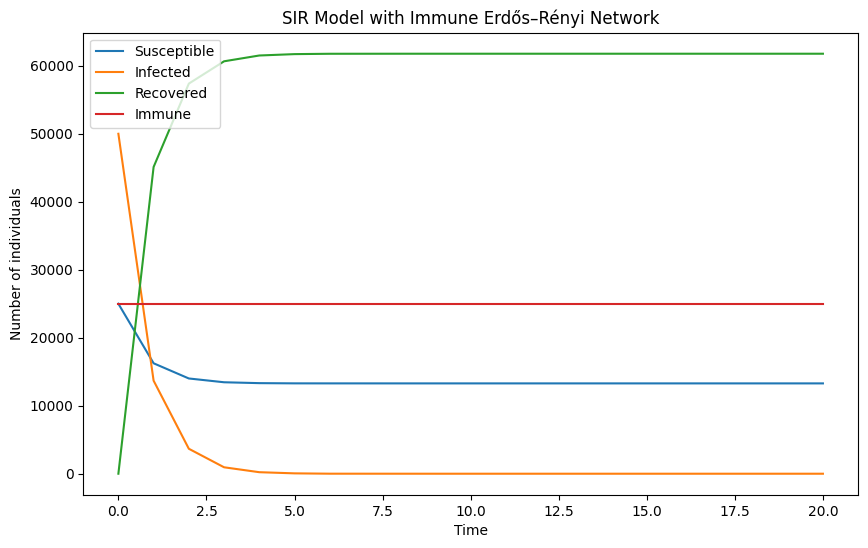

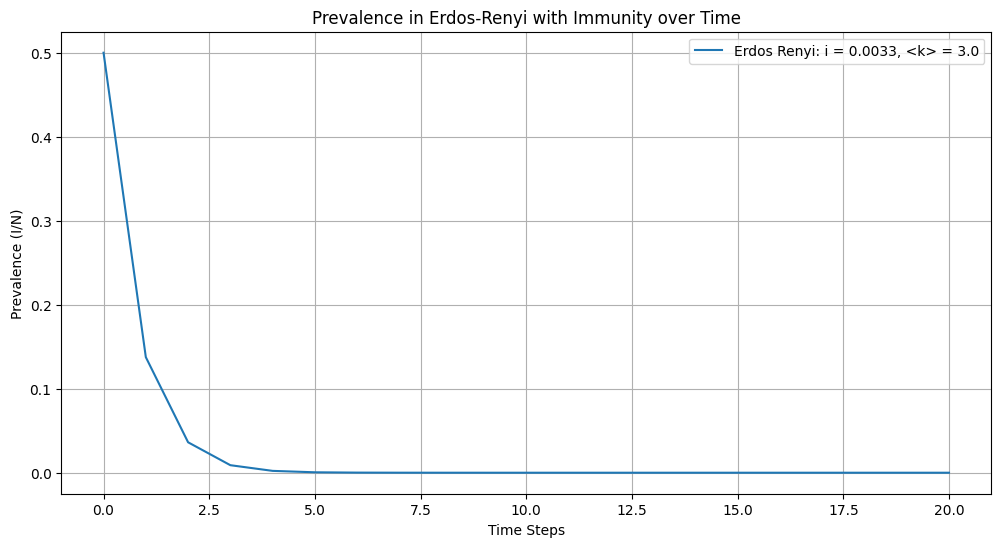

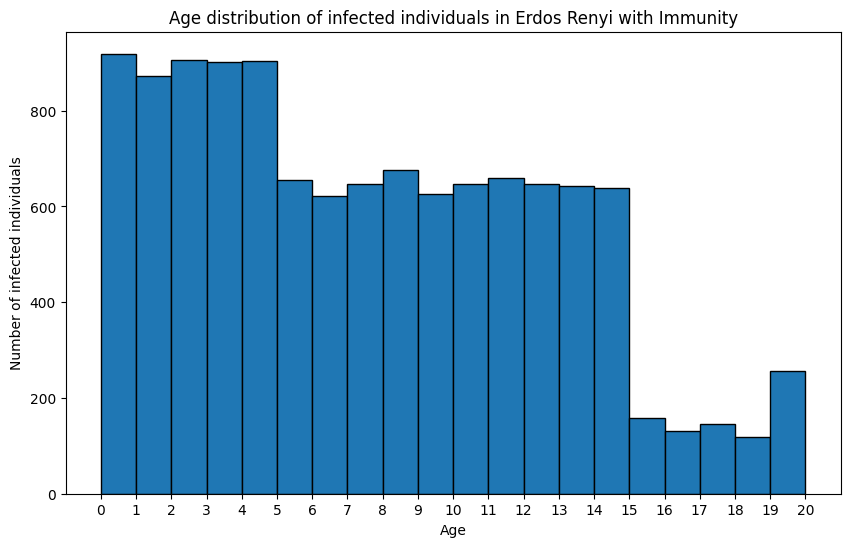

In [11]:
# Erdos-Renyi Network with Immunity

def Imm_er(N, i, r, k, initial_infected, timesteps, age, initial_age, immune_count, immune_rate):
    # Create an Erdos-Renyi using nx
    # probability of edge formation
    p = k / (N - 1)  
    G = nx.fast_gnp_random_graph(N, p)

    # Assign ages to nodes based on the provided age distribution
    ages = {node: np.random.choice(age) for node in G.nodes()}

    # Initialize the infection based on age groups
    infected = set()
    for age_group, fraction in initial_age.items():
        # Nodes within age group
        age_group_nodes = [node for node, age in ages.items() if age_group[0] <= age <= age_group[1]]
        # Choose random nodes infected initially
        initial_infected_n = np.random.choice(age_group_nodes, size=int(fraction * initial_infected), replace=False)
        infected.update(initial_infected_n)

    non_infected = set(G.nodes()) - infected
    Immune = set(np.random.choice(list(non_infected), size=int(len(non_infected)*immune_count), replace=False))    
    # Calculate susceptible nodes
    susceptible = non_infected - Immune
    # Set of recovered nodes is empty initially
    recovered = set()
    
    # Record the prevalence over time
    # Susceptible nodes initially
    S = [len(susceptible)]
    # Infected nodes initially
    I = [len(infected)]
    # Recovered nodes initially
    R = [len(recovered)]
    # Immune nodes initially
    IM = [len(Immune)]
    # Prevalence initially
    prevalence = [len(infected) / N]
    # List for infected individuals by different age groups per timestep
    infected_ages = []

    # Simulate the spread over time
    for _ in range(timesteps):
        new_infected = set()
        new_recovered = set()
        
        # Transmit infection based on infection rates for age groups
        for node in set(infected):
            node_age = ages[node]
            # Calculate infection rate based on age
            age_i = age_based_infection_rate(node_age, i)
            
            # Infect neighbors
            for neighbor in G.neighbors(node):
                # Infect susceptible nodes for age-related infection rate
                if neighbor in susceptible and np.random.random() < age_i:
                    new_infected.add(neighbor)
                # Infect immune nodes based on immune rate
                elif neighbor in Immune and np.random.random() < immune_rate:
                    new_infected.add(neighbor)
            # Probability for recovery
            if np.random.random() < r:
                new_recovered.add(node)
                infected.remove(node)

        infected.update(new_infected)
        recovered.update(new_recovered)
        susceptible -= new_infected
        new_infected_ages = [ages[node] for node in new_infected]
        infected_ages.append(new_infected_ages)

        S.append(len(susceptible))
        I.append(len(infected))
        R.append(len(recovered))
        IM.append(len(Immune))
        prevalence.append(len(infected) / N)

    return S, I, R, IM, prevalence, infected_ages


SIm, IIm, RIm, IM, _ , infected_ages_Im= Imm_er(N, i_1, r, k_1, initial_infected, timesteps, age, initial_age, immune_count, immune_rate)
prevalence_Im = []
infected_ages_Im = [age for ages in infected_ages_Im for age in ages]

# Simulations for collecting data
for _ in range(simulations):
    _, _, _, _, preva_all_Im, _ = Imm_er(N, i_1, r, k_1, initial_infected, timesteps, age, initial_age, immune_count, immune_rate)
    prevalence_Im.append(preva_all_Im)
    
#Calculate average prevalence in this situation with immunity
avg_prevalence_Im = np.mean(prevalence_Im, axis=0)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(SIm, label='Susceptible')
plt.plot(IIm, label='Infected')
plt.plot(RIm, label='Recovered')
plt.plot(IM, label='Immune')
plt.xlabel('Time')
plt.ylabel('Number of individuals')
plt.legend()
plt.title('SIR Model with Immune Erdős–Rényi Network')
plt.show()

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(avg_prevalence_Im, label=f'Erdos Renyi: i = {i_1}, <k> = {k_1}')
plt.xlabel('Time Steps')
plt.ylabel('Prevalence (I/N)')
plt.title('Prevalence in Erdos-Renyi with Immunity over Time')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
plt.hist(infected_ages_Im, bins=range(0, 21), edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Number of infected individuals')
plt.title('Age distribution of infected individuals in Erdos Renyi with Immunity')
plt.xticks(range(0, 21))
plt.show()


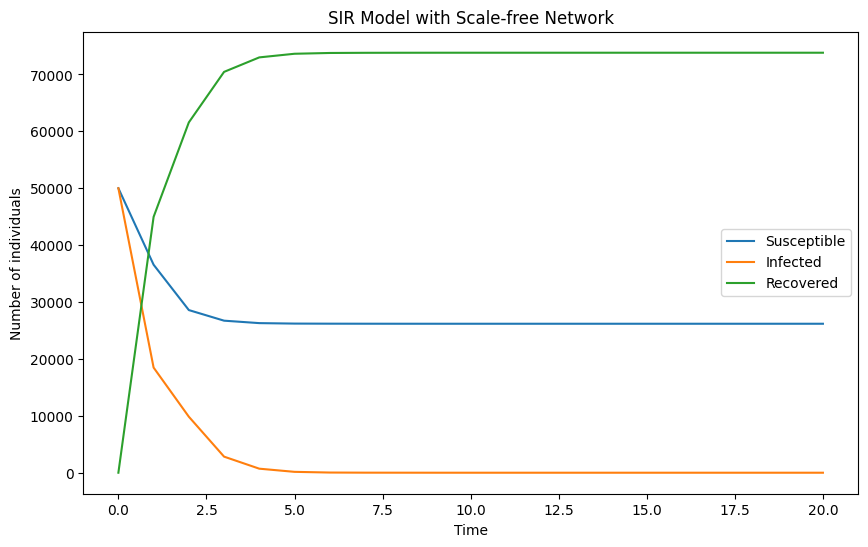

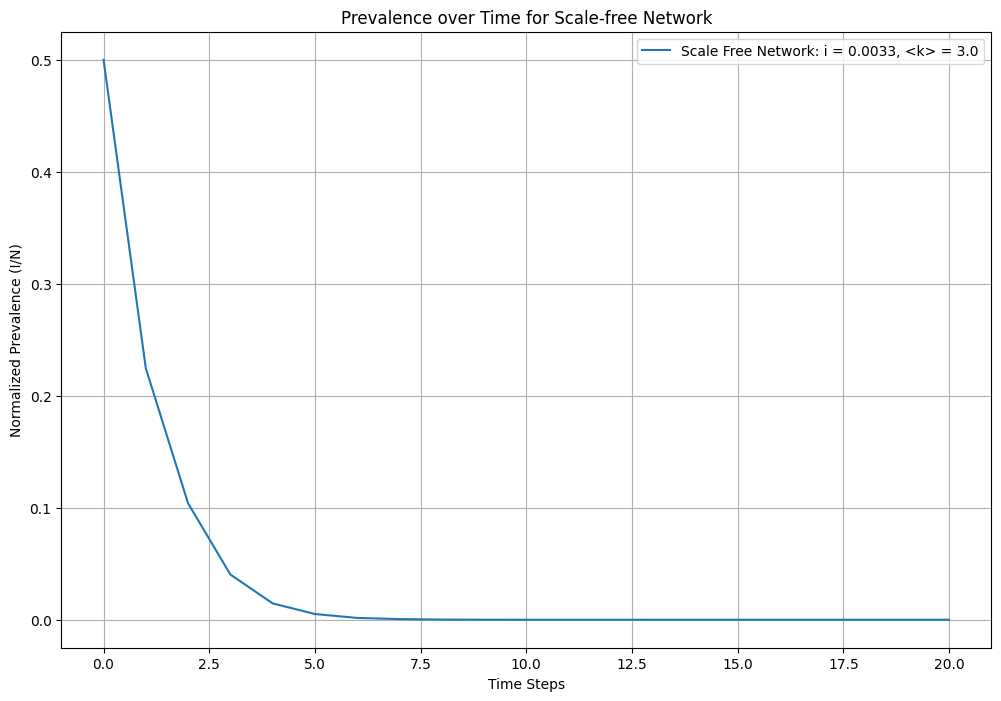

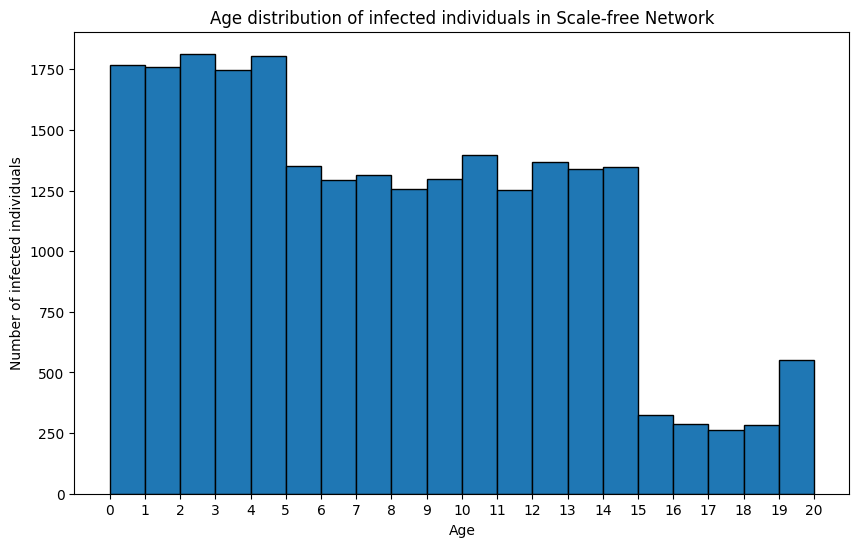

In [12]:
# Scale-free network

def sir_model_sf(N, i, k, initial_infected, timesteps, gamma, age, initial_age):
    # Generate a sequence of expected degrees with a power-law distribution
    s = nx.utils.powerlaw_sequence(N, gamma)
    # Rescale the expected degrees to match the given average degree
    s = np.array(s) * k / np.mean(s)
    # Generate the scale-free network
    G = nx.expected_degree_graph(s, selfloops=False)

    ages = {node: np.random.choice(age) for node in G.nodes()}

    # Initialize the infection based on age groups    
    infected = set()
    for age_group, fraction in initial_age.items():
        # Nodes within age group
        age_group_nodes = [node for node, age in ages.items() if age_group[0] <= age <= age_group[1]]
        # size = min(int(fraction * initial_infected), len(age_group_nodes))
        # Choose random nodes infected initially
        initial_infected_n = np.random.choice(age_group_nodes, size=int(fraction * initial_infected), replace=False)
        infected.update(initial_infected_n)
    # Calculate susceptible nodes
    susceptible = set(G.nodes()) - infected
    # Set of recovered nodes is empty initially
    recovered = set()
    
    # Record the prevalence over time
    # Susceptible nodes initially
    S = [len(susceptible)]
    # Infected nodes initially
    I = [len(infected)]
    # Recovered nodes initially
    R = [len(recovered)]
    # Prevalence initially
    prevalence = [len(infected) / N]
    # List for infected individuals by different age groups per timestep
    infected_ages = []

    # Simulate the spread over time
    for _ in range(timesteps):
        new_infected = set()
        new_recovered = set()
        
        # Transmit infection based on infection rates for age groups
        for node in set(infected):
            node_age = ages[node]
            # Calculate infection rate based on age
            age_i = age_based_infection_rate(node_age, i)
            
            # Infect neighbors
            for neighbor in G.neighbors(node):
                # Infect susceptible nodes for age-related infection rate
                if neighbor in susceptible and np.random.random() < age_i:
                    new_infected.add(neighbor)
             # Probability for recovery 
            if np.random.random() < r:
                new_recovered.add(node)
                infected.remove(node)
                
        infected.update(new_infected)
        recovered.update(new_recovered)
        susceptible -= new_infected

        S.append(len(susceptible))
        I.append(len(infected))
        R.append(len(recovered))
        prevalence.append(len(infected) / N)
        new_infected_ages = [ages[node] for node in new_infected]
        infected_ages.append(new_infected_ages)

    return S, I, R, prevalence, infected_ages

# Parameters for the simulations
gamma = 2.5

# Run simulations for the scale-free network
Sf, If, Rf, _, i_age = sir_model_sf(N, i_1, k_1, initial_infected, timesteps, gamma, age, initial_age)
prevalence_sf = []
i_age = [age for ages in i_age for age in ages]

for _ in range(simulations):
    _, _, _, preva_sf, _ = sir_model_sf(N, i_1, k_1, initial_infected, timesteps, gamma, age, initial_age)
    prevalence_sf.append(preva_all)

avg_prevalence_sf = np.mean(prevalence_sf, axis=0)

# Plot SIR
plt.figure(figsize=(10, 6))
plt.plot(Sf, label='Susceptible')
plt.plot(If, label='Infected')
plt.plot(Rf, label='Recovered')
plt.xlabel('Time')
plt.ylabel('Number of individuals')
plt.legend()
plt.title('SIR Model with Scale-free Network')
plt.show()

# Plotting the results for comparison
plt.figure(figsize=(12, 8))
plt.plot(avg_prevalence_sf, label=f'Scale Free Network: i = {i_1}, <k> = {k_1}')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Prevalence (I/N)')
plt.title('Prevalence over Time for Scale-free Network')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(i_age, bins=range(0, 21), edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Number of infected individuals')
plt.title('Age distribution of infected individuals in Scale-free Network')
plt.xticks(range(0, 21))
plt.show()


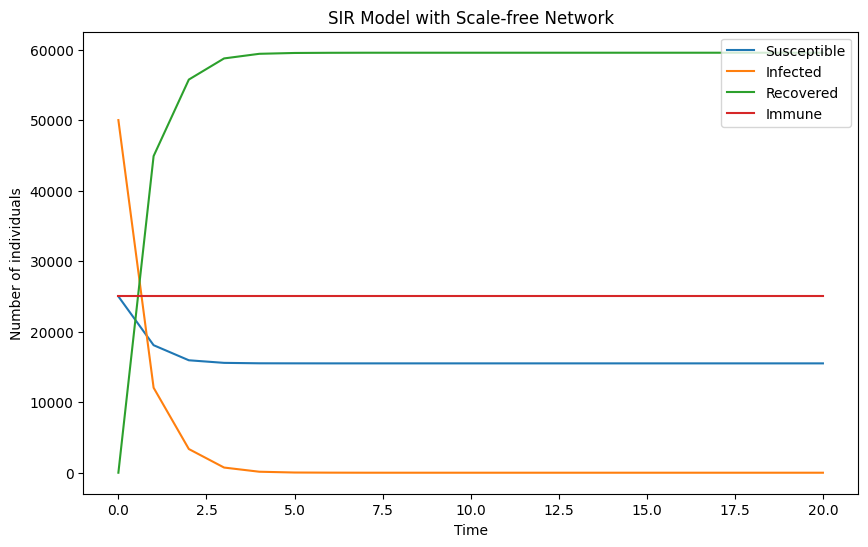

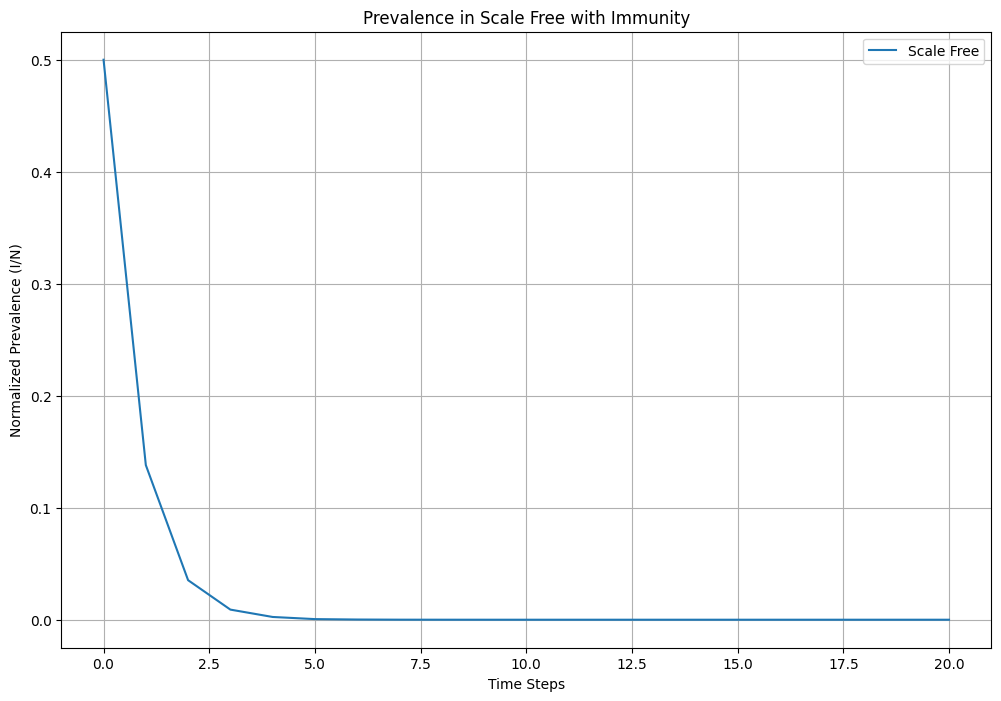

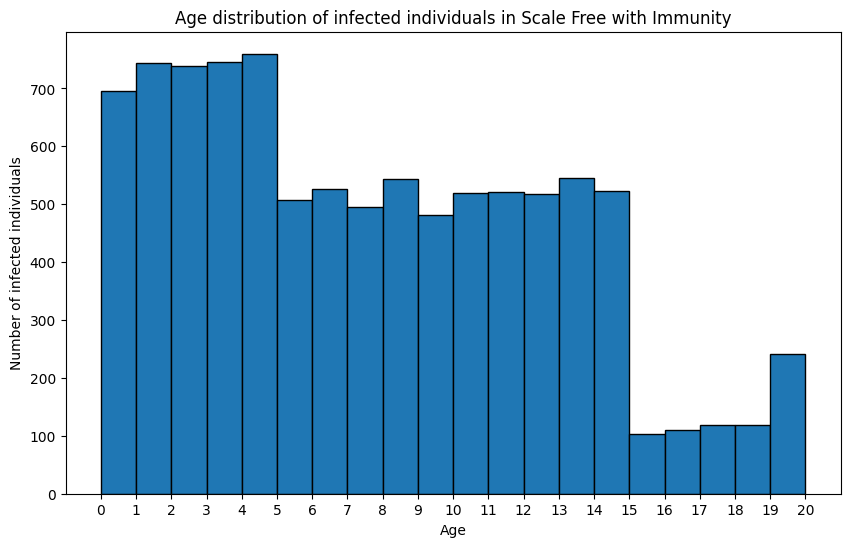

In [13]:
# Scale-free network with Immunity

def Imm_sf(N, i, k, initial_infected, timesteps, gamma, age, initial_age, immune_count):
    # Generate a sequence of expected degrees with a power-law distribution
    s = nx.utils.powerlaw_sequence(N, gamma)
    # Rescale the expected degrees to match the given average degree
    s = np.array(s) * k / np.mean(s)
    # Generate the scale-free network
    G = nx.expected_degree_graph(s, selfloops=False)

    ages = {node: np.random.choice(age) for node in G.nodes()}

    # Initialize the infection based on age groups    
    infected = set()
    for age_group, fraction in initial_age.items():
        # Nodes within age group
        age_group_nodes = [node for node, age in ages.items() if age_group[0] <= age <= age_group[1]]
        # Choose random nodes infected initially
        initial_infected_n = np.random.choice(age_group_nodes, size=int(fraction * initial_infected), replace=False)
        infected.update(initial_infected_n)
        
    # Non-infected nodes
    non_infected = set(G.nodes()) - infected
    # Choose a portion of non-infected nodes as immune
    Immune = set(np.random.choice(list(non_infected), size=int(len(non_infected)*immune_count), replace=False))
    # Calculate susceptible nodes
    susceptible = non_infected - Immune
    # Set of recovered nodes is empty initially
    recovered = set()
    
    # Record the prevalence over time
    # Susceptible nodes initially
    S = [len(susceptible)]
    # Infected nodes initially
    I = [len(infected)]
    # Recovered nodes initially
    R = [len(recovered)]
    # Immune nodes initially
    IM = [len(Immune)]
    # Prevalence initially
    prevalence = [len(infected) / N]
    # List for infected individuals by different age groups per timestep
    infected_ages = []

    # Simulate the spread over time
    for _ in range(timesteps):
        new_infected = set()
        new_recovered = set()
        
        # Transmit infection based on infection rates for age groups
        for node in set(infected):
            node_age = ages[node]
            # Calculate infection rate based on age
            age_i = age_based_infection_rate(node_age, i)
            
            # Infect neighbors
            for neighbor in G.neighbors(node):
                # Infect susceptible nodes for age-related infection rate
                if neighbor in susceptible and np.random.random() < age_i:
                    new_infected.add(neighbor)
                # Infect immune nodes based on immune rate
                elif neighbor in Immune and np.random.random() < immune_rate:
                    new_infected.add(neighbor)
                    
            # Probability for recovery    
            if np.random.random() < r:
                new_recovered.add(node)
                infected.remove(node)
                
        infected.update(new_infected)
        recovered.update(new_recovered)
        susceptible -= new_infected

        S.append(len(susceptible))
        I.append(len(infected))
        R.append(len(recovered))
        IM.append(len(Immune))
        prevalence.append(len(infected) / N)
        new_infected_ages = [ages[node] for node in new_infected]
        infected_ages.append(new_infected_ages)

    return S, I, R, IM, prevalence, infected_ages

# Parameters for the simulations
gamma = 2.5

# Run simulations for the scale-free network for case (i)
SfI, IfI, RfI, Imf,  _, i_ageI = Imm_sf(N, i_1, k_1, initial_infected, timesteps, gamma, age, initial_age, immune_count)
prevalence_sf_Im = []
i_ageI = [age for ages in i_ageI for age in ages]

for _ in range(simulations):
    _, _, _, _, preva_sf_Im, _ = Imm_sf(N, i_1, k_1, initial_infected, timesteps, gamma, age, initial_age, immune_count)
    prevalence_sf_Im.append(preva_all_Im)

avg_prevalence_sf_Im = np.mean(prevalence_sf_Im, axis=0)

# Plot SIR
plt.figure(figsize=(10, 6))
plt.plot(SfI, label='Susceptible')
plt.plot(IfI, label='Infected')
plt.plot(RfI, label='Recovered')
plt.plot(Imf, label='Immune')
plt.xlabel('Time')
plt.ylabel('Number of individuals')
plt.legend()
plt.title('SIR Model with Scale-free Network')
plt.show()

# Plotting the results for comparison
plt.figure(figsize=(12, 8))
plt.plot(avg_prevalence_sf_Im, label=f'Scale Free')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Prevalence (I/N)')
plt.title('Prevalence in Scale Free with Immunity')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(i_ageI, bins=range(0, 21), edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Number of infected individuals')
plt.title('Age distribution of infected individuals in Scale Free with Immunity')
plt.xticks(range(0, 21))
plt.show()


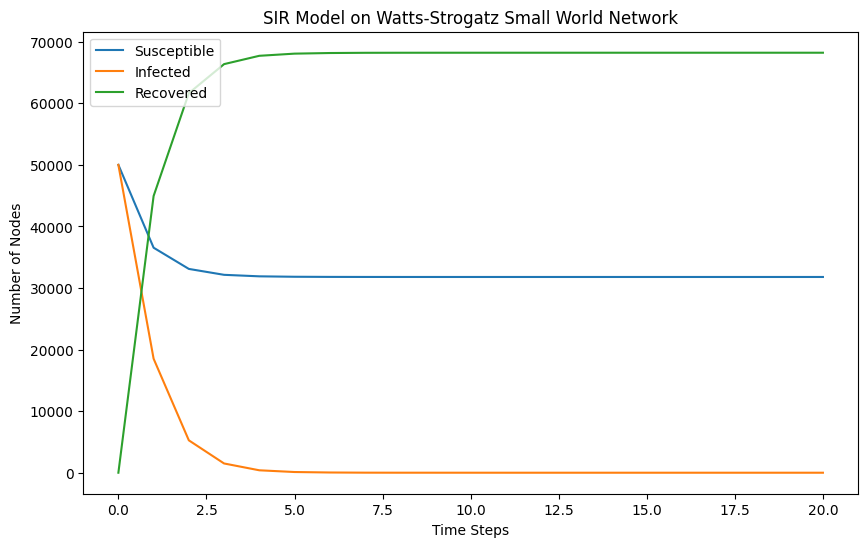

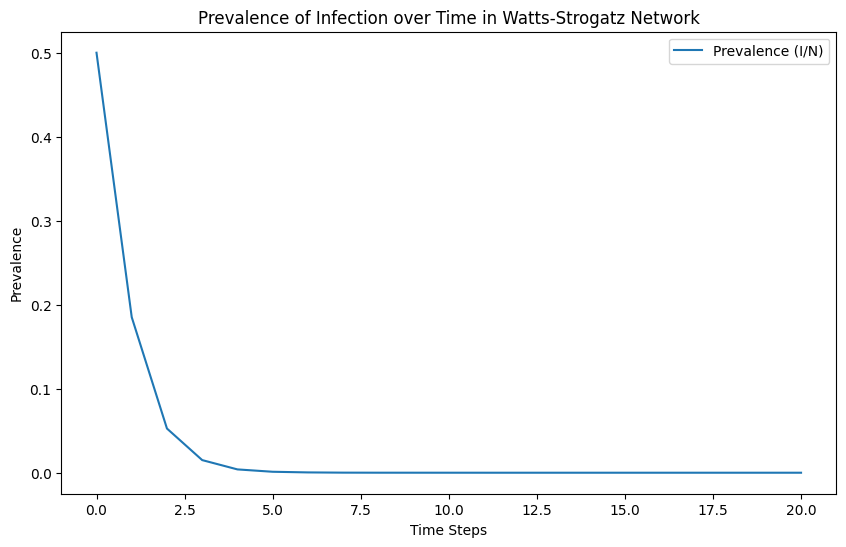

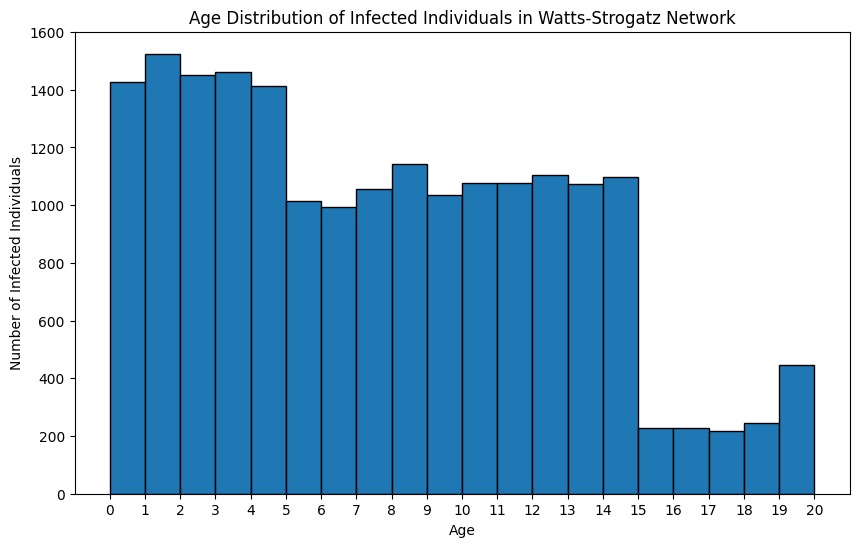

In [18]:
# Small World Network

def sir_model_watts_strogatz(N, k, p, i, r, initial_infected, timesteps, age_distribution, initial_age):
    # Generate a Watts-Strogatz small-world network
    G = nx.watts_strogatz_graph(N, int(k), int(p))

    # Assign random ages to each node based on the provided age distribution
    ages = {node: np.random.choice(age_distribution) for node in G.nodes()}

    # Initialize the infection based on age distribution and initial infection rates
    infected = set()
    for age_group, fraction in initial_age.items():
        age_group_nodes = [node for node, age in ages.items() if age_group[0] <= age <= age_group[1]]
        initial_infected_n = np.random.choice(age_group_nodes, size=int(fraction * initial_infected), replace=False)
        infected.update(initial_infected_n)
    
    # Define sets for susceptible and recovered individuals
    susceptible = set(G.nodes()) - infected
    recovered = set()

    # Initialize lists to keep track of SIR model results
    S, I, R = [len(susceptible)], [len(infected)], [len(recovered)]
    prevalence = [len(infected) / N]
    infected_ages = []

    # Iterate over the defined timesteps
    for _ in range(timesteps):
        new_infected = set()
        new_recovered = set()

        # Update infection and recovery status
        for node in infected.copy():
            node_age = ages[node]
            age_i = age_based_infection_rate(node_age, i)
            
            # Spread the infection to susceptible neighbors
            for neighbor in G.neighbors(node):
                if neighbor in susceptible and np.random.random() < age_i:
                    new_infected.add(neighbor)
                    infected_ages.append(ages[neighbor])
            # Determine if infected nodes recover
            if np.random.random() < r:
                new_recovered.add(node)
                infected.remove(node)

        # Update the sets and lists for each step
        infected.update(new_infected)
        recovered.update(new_recovered)
        susceptible -= new_infected

        S.append(len(susceptible))
        I.append(len(infected))
        R.append(len(recovered))
        prevalence.append(len(infected) / N)

    return S, I, R, prevalence, infected_ages

# Define parameters
p = k_1 / (N - 1)  # Rewiring probability
timesteps = 20  # Number of timesteps to simulate
age_distribution = range(0, 21)  # Age distribution for the population

# Run the SIR model simulation
Ssm, Ism, Rsm, prevalence_sm, infected_ages_sm = sir_model_watts_strogatz(N, k_1, p, i_1, r, initial_infected, timesteps, age_distribution, initial_age)

# Plotting the results of the SIR model
plt.figure(figsize=(10, 6))
plt.plot(Ssm, label='Susceptible')  
plt.plot(Ism, label='Infected')     
plt.plot(Rsm, label='Recovered')    
plt.xlabel('Time Steps')
plt.ylabel('Number of Nodes')
plt.legend()
plt.title('SIR Model on Watts-Strogatz Small World Network')
plt.show()

# Plotting the prevalence of infection over time
plt.figure(figsize=(10, 6))
plt.plot(prevalence_sm, label='Prevalence (I/N)')
plt.xlabel('Time Steps')
plt.ylabel('Prevalence')
plt.legend()
plt.title('Prevalence of Infection over Time in Watts-Strogatz Network')
plt.show()

# Plotting the age distribution of infected individuals
plt.figure(figsize=(10, 6))
plt.hist(infected_ages_sm, bins=range(0, 21), edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Number of Infected Individuals')
plt.title('Age Distribution of Infected Individuals in Watts-Strogatz Network')
plt.xticks(range(0, 21))
plt.show()


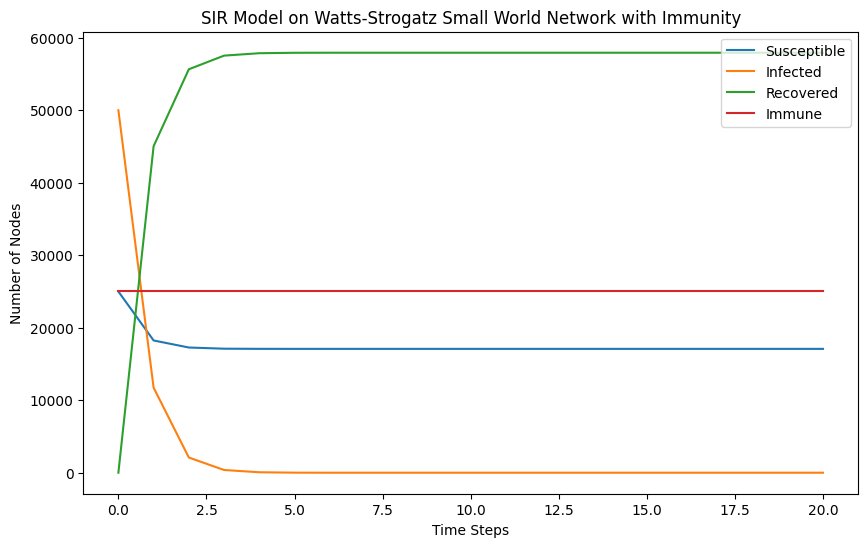

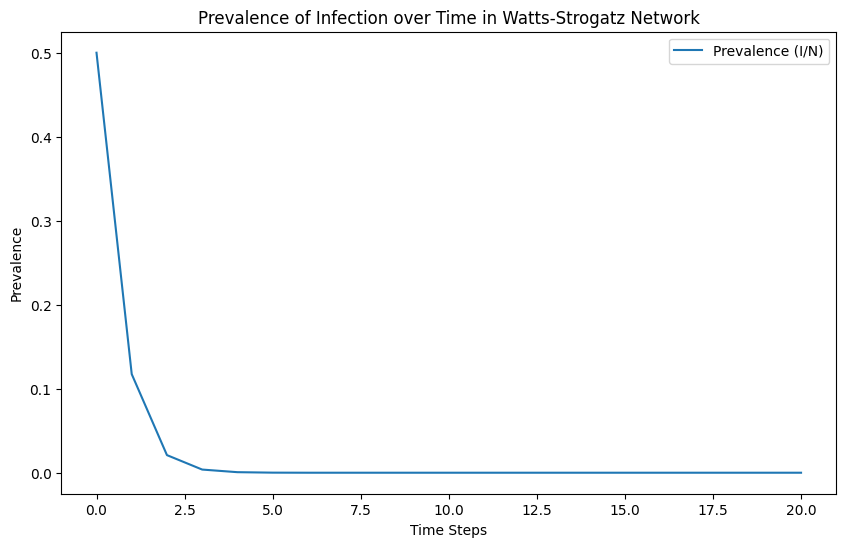

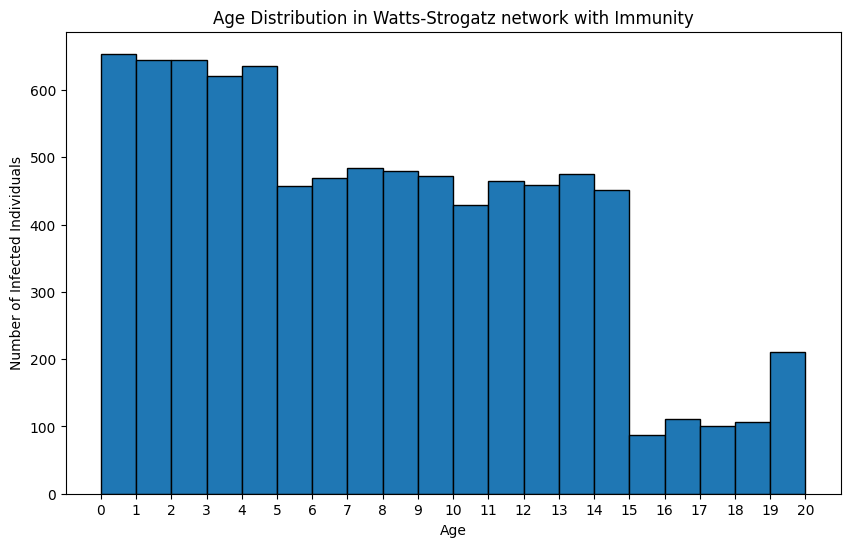

In [15]:
# Small World Network with immunity

def sir_model_watts_strogatz_Im(N, k, p, i, r, initial_infected, timesteps, age_distribution, initial_age, immune_count):
    # Create a Watts-Strogatz small world network with N nodes, average degree k, and rewiring probability p
    G = nx.watts_strogatz_graph(N, int(k), int(p))

    # Assign random ages to each node based on the provided age distribution
    ages = {node: np.random.choice(age_distribution) for node in G.nodes()}

    # Initialize infection among nodes based on age groups and initial infection rates
    infected = set()
    for age_group, fraction in initial_age.items():
        age_group_nodes = [node for node, age in ages.items() if age_group[0] <= age <= age_group[1]]
        initial_infected_n = np.random.choice(age_group_nodes, size=int(fraction * initial_infected), replace=False)
        infected.update(initial_infected_n)
    
    # Define sets for non-infected, immune, susceptible, and recovered nodes
    non_infected = set(G.nodes()) - infected
    Immune = set(np.random.choice(list(non_infected), size=int(len(non_infected)*immune_count), replace=False))
    susceptible = non_infected - Immune
    recovered = set()

    # Initialize lists to keep track of the numbers of susceptible, infected, recovered, and immune individuals over time
    S, I, R, IM = [len(susceptible)], [len(infected)], [len(recovered)], [len(Immune)]
    prevalence = [len(infected) / N]
    infected_ages = []

    # Simulate the SIR model over the specified number of timesteps
    for _ in range(timesteps):
        new_infected = set()
        new_recovered = set()

        # Process each infected node for potential recovery and infection spread
        for node in infected.copy():
            node_age = ages[node]
            age_i = age_based_infection_rate(node_age, i)
            
            # Spread infection to susceptible and immune neighbors
            for neighbor in G.neighbors(node):
                if neighbor in susceptible and np.random.random() < age_i:
                    new_infected.add(neighbor)
                    infected_ages.append(ages[neighbor])
                elif neighbor in Immune and np.random.random() < immune_rate:
                    new_infected.add(neighbor)
                    infected_ages.append(ages[neighbor])
            # Recover the infected node with a probability r
            if np.random.random() < r:
                new_recovered.add(node)
                infected.remove(node)

        # Update the sets of susceptible, infected, and recovered nodes
        infected.update(new_infected)
        recovered.update(new_recovered)
        susceptible -= new_infected

        # Update the counts for each group at this timestep
        S.append(len(susceptible))
        I.append(len(infected))
        R.append(len(recovered))
        IM.append(len(Immune))
        prevalence.append(len(infected) / N)

    return S, I, R, IM, prevalence, infected_ages

# Define parameters for the model
p = k_1 / (N - 1)  # Calculate the rewiring probability p
timesteps = 20     # Set the number of timesteps for the simulation
age_distribution = range(0, 21)  # Define the age distribution for the population

# Run the SIR model simulation with immunity
Ssmi, Ismi, Rsmi, Imsi, prevalence_smi, infected_ages_smi = sir_model_watts_strogatz_Im(N, k_1, p, i_1, r, initial_infected, timesteps, age_distribution, initial_age, immune_count)

# Plotting the results of the SIR model with immunity
plt.figure(figsize=(10, 6))
plt.plot(Ssmi, label='Susceptible')  # Plot the susceptible curve
plt.plot(Ismi, label='Infected')     # Plot the infected curve
plt.plot(Rsmi, label='Recovered')    # Plot the recovered curve
plt.plot(Imsi, label='Immune')       # Plot the immune curve
plt.xlabel('Time Steps')
plt.ylabel('Number of Nodes')
plt.legend()
plt.title('SIR Model on Watts-Strogatz Small World Network with Immunity')
plt.show()

# Plot the prevalence of infection over time
plt.figure(figsize=(10, 6))
plt.plot(prevalence_smi, label='Prevalence (I/N)')
plt.xlabel('Time Steps')
plt.ylabel('Prevalence')
plt.legend()
plt.title('Prevalence of Infection over Time in Watts-Strogatz Network')

# plot age distribution in Watts-Strogatz network with immunity
plt.figure(figsize=(10, 6))
plt.hist(infected_ages_smi, bins=range(0, 21), edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Number of Infected Individuals')
plt.title('Age Distribution in Watts-Strogatz network with Immunity')
plt.xticks(range(0, 21))
plt.show()

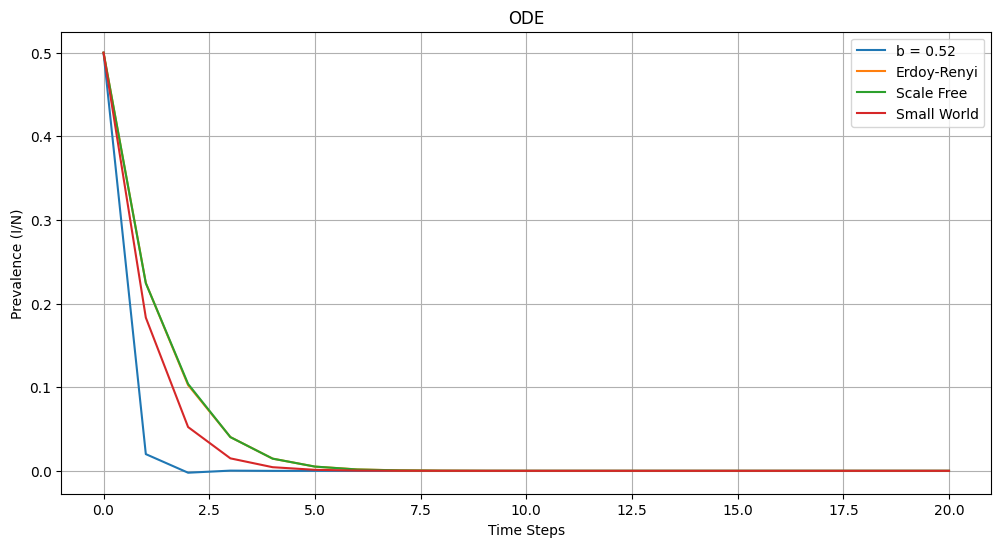

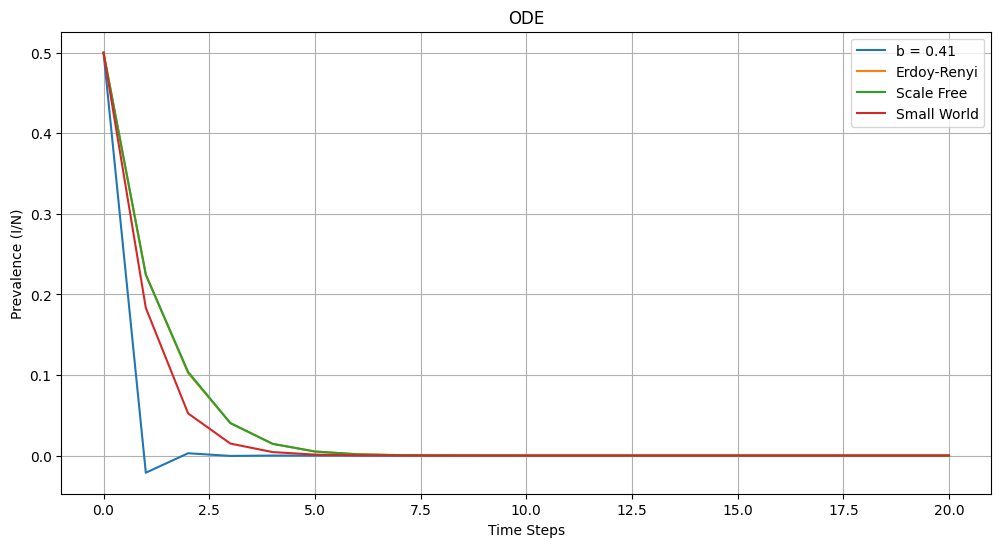

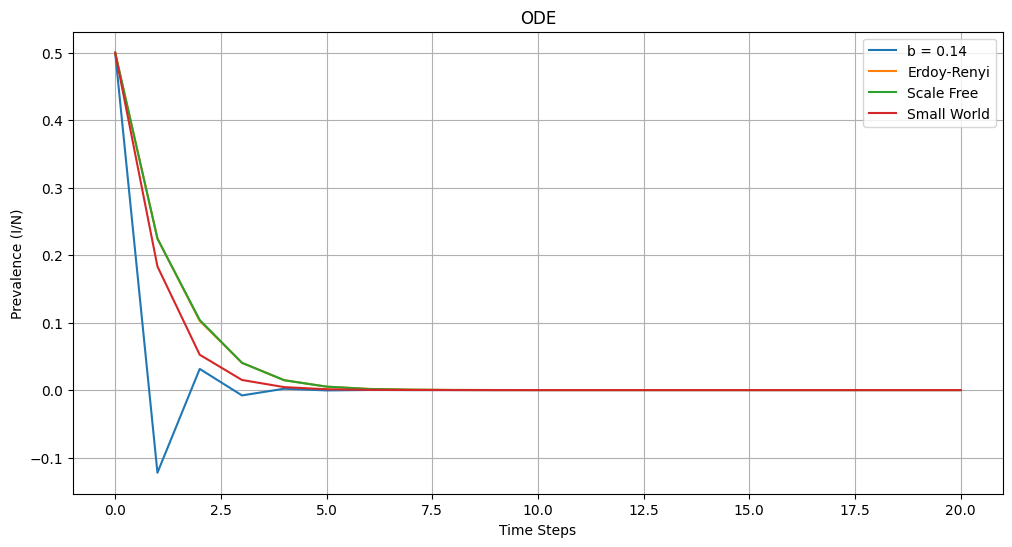

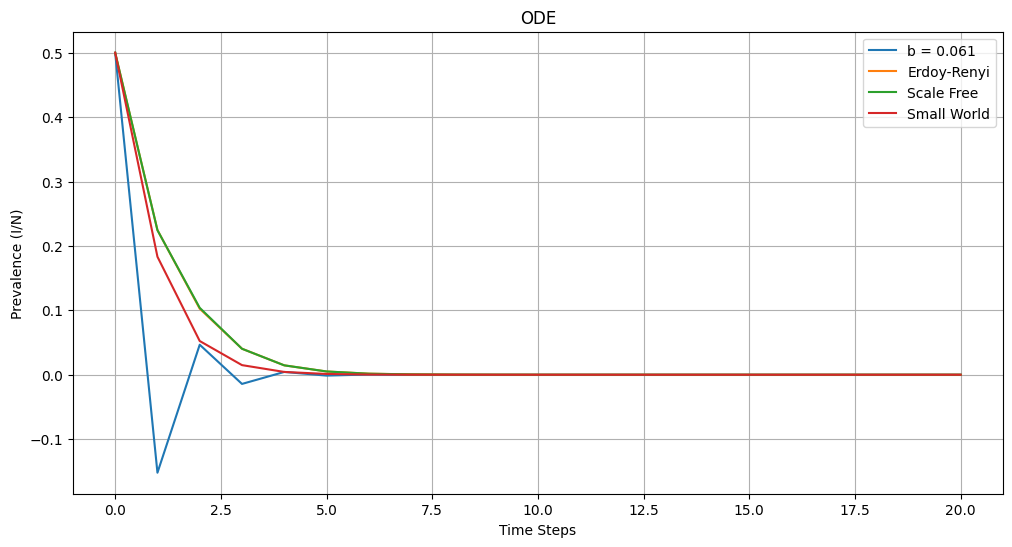

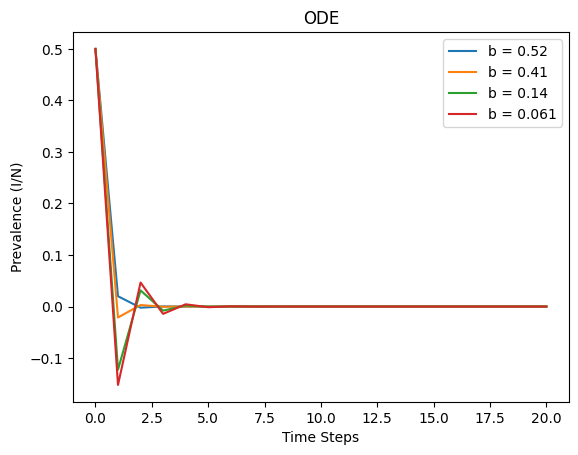

In [16]:
# Euler Method ODE 
# alter the Euler method to solve the SIR model
def euler_si_model(N, b, g, I0, S0, R0, dt, timesteps):
    # Initialize arrays to store the values of S, I, and R over time
    I = np.zeros(timesteps + 1)
    S = np.zeros(timesteps + 1)
    R = np.zeros(timesteps + 1)

    I[0] = I0
    S[0] = S0
    R[0] = R0
    
    # the Euler method to solve the ODEs
    for t in range(1, timesteps + 1):
        dIdt = b * (I[t-1] * S[t-1])/N - g * I[t-1]
        dSdt = -b * (I[t-1] * S[t-1])/N
        dRdt = g * I[t-1]
        
        I[t] = I[t-1] + dIdt * dt
        S[t] = S[t-1] + dSdt * dt
        R[t] = R[t-1] + dRdt * dt
    
    return S, I, R

# Parameters
b = [0.52, 0.41, 0.14, 0.061]
g = 0.9

# Initial number of infected individuals
I0 = 0.5 * N 
# Initial number of susceptible individuals 
S0 = N - I0    
# Initial number of recovered individuals
R0 = 0

dt = 1.5  

# Execution of the ODE
S_ode, I_ode, R_ode = [], [], []
for rate in b:
    So, Io, Ro = euler_si_model(N, rate, g, I0, S0, R0, dt, timesteps)
    S_ode.append(So)
    I_ode.append(Io/N)
    R_ode.append(Ro)

for i in range(len(b)):
    plt.figure(figsize=(12, 6))
    plt.plot(I_ode[i], label=f'b = {b[i]}')
    plt.plot(avg_prevalence, label=f'Erdoy-Renyi')
    plt.plot(avg_prevalence_sf, label=f'Scale Free')
    plt.plot(prevalence_sm, label='Small World')
    plt.xlabel('Time Steps')
    plt.ylabel('Prevalence (I/N)')
    plt.title('ODE')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the results of the ODE simulations
for i in range(len(b)):
    plt.plot(I_ode[i], label=f'b = {b[i]}')
    plt.legend()
    plt.xlabel('Time Steps')
    plt.ylabel('Prevalence (I/N)')
    plt.title('ODE')

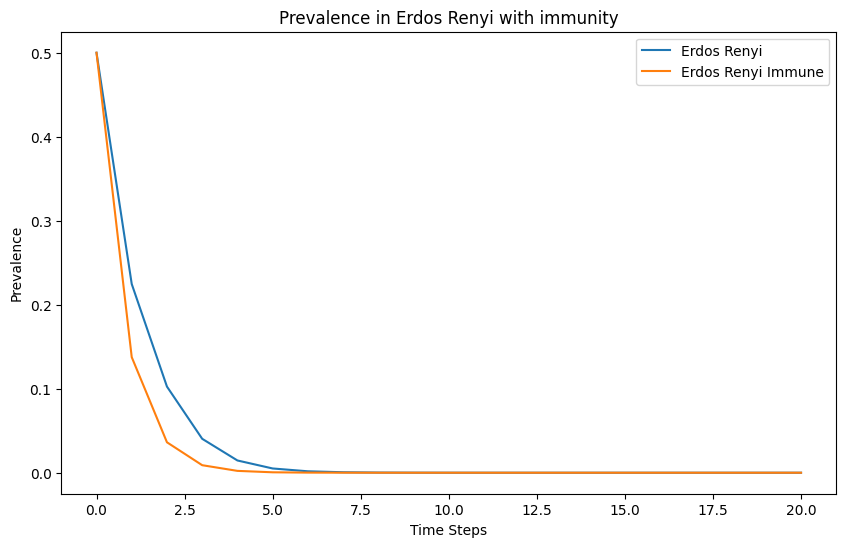

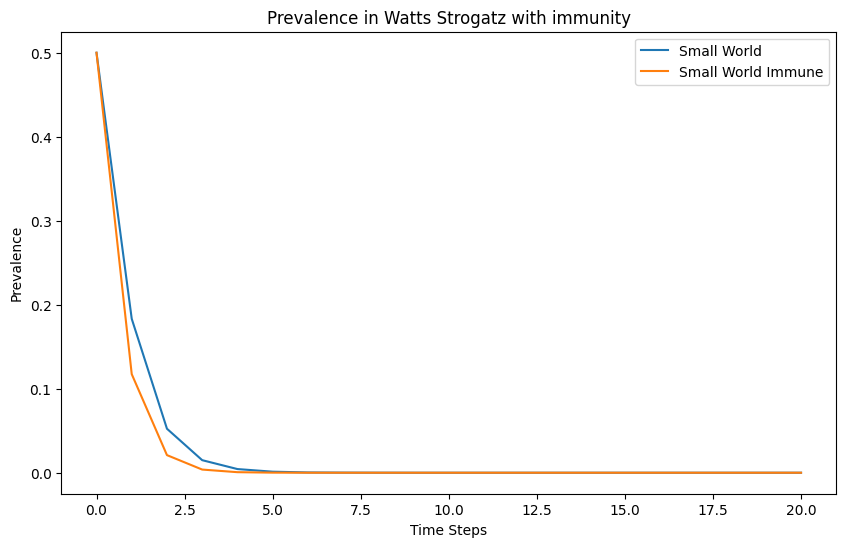

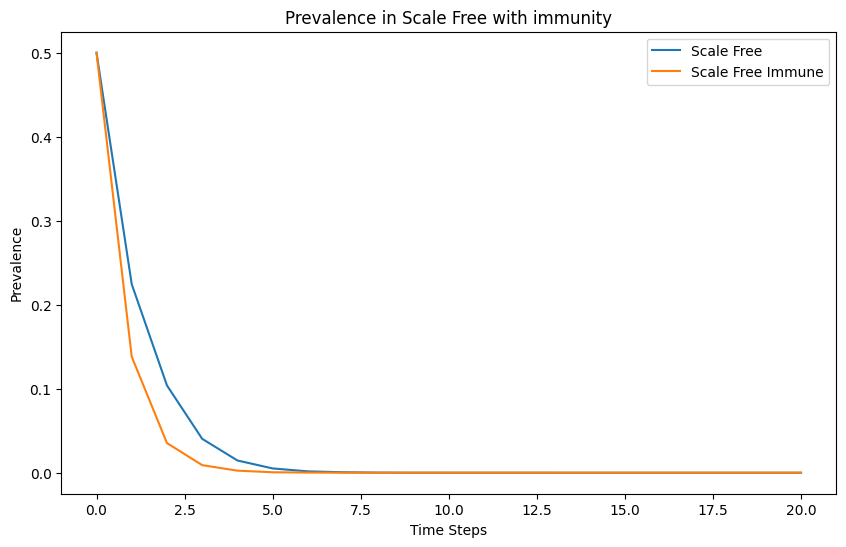

In [17]:
# Plot the prevalence of the Erdos-Renyi network simulation
plt.figure(figsize=(10, 6))
plt.plot(avg_prevalence, label=f'Erdos Renyi')
plt.plot(avg_prevalence_Im, label=f'Erdos Renyi Immune')
plt.xlabel('Time Steps')
plt.ylabel('Prevalence')
plt.legend()
plt.title('Prevalence in Erdos Renyi with immunity')
plt.show()

# Plot the prevalence of the Small World network simulation
plt.figure(figsize=(10, 6))
plt.plot(prevalence_sm, label='Small World')
plt.plot(prevalence_smi, label='Small World Immune')
plt.xlabel('Time Steps')
plt.ylabel('Prevalence')
plt.legend()
plt.title('Prevalence in Watts Strogatz with immunity')
plt.show()

# Plot the prevalence of the Scale Free network simulation
plt.figure(figsize=(10, 6))
plt.plot(avg_prevalence_sf, label=f'Scale Free')
plt.plot(avg_prevalence_sf_Im, label=f'Scale Free Immune')
plt.xlabel('Time Steps')
plt.ylabel('Prevalence')
plt.legend()
plt.title('Prevalence in Scale Free with immunity')
plt.show()